# **Music Recommendation System**

In [ ]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from collections import defaultdict
import difflib

import warnings
warnings.filterwarnings("ignore")



# **Reading Data**

In [ ]:
data = pd.read_csv('/content/data.csv')
genre_data = pd.read_csv('/content/data_by_genres.csv')
year_data = pd.read_csv('/content/data_by_year.csv')
artist_data = pd.read_csv('/content/data_by_artist.csv')
data_w_genres= pd.read_csv('/content/data_w_genres.csv')

In [ ]:
data.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1.0,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4.0,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1.0,Clancy Lowered the Boom,5.0,1921,0.4150,60.936


In [ ]:
genre_data.head(2)

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.3616,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.1310,-16.854000,0.076817,120.285667,0.221750,52.500000,5


In [ ]:
year_data.head(2)

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.20571,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.24072,-19.275282,0.116655,100.884521,0.535549,0.140845,10


In [ ]:
artist_data.head(2)

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690,0.176212,103.044154,0.268865,30.576923,5


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30197 entries, 0 to 30196
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           30197 non-null  float64
 1   year              30197 non-null  int64  
 2   acousticness      30197 non-null  float64
 3   artists           30197 non-null  object 
 4   danceability      30197 non-null  float64
 5   duration_ms       30197 non-null  int64  
 6   energy            30197 non-null  float64
 7   explicit          30197 non-null  int64  
 8   id                30197 non-null  object 
 9   instrumentalness  30197 non-null  float64
 10  key               30197 non-null  int64  
 11  liveness          30196 non-null  float64
 12  loudness          30196 non-null  float64
 13  mode              30196 non-null  float64
 14  name              30196 non-null  object 
 15  popularity        30196 non-null  float64
 16  release_date      30196 non-null  object

In [ ]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [ ]:
data['decade'] = data['year'].apply(lambda year : f'{(year//10)*10}s' )

# **EDA(Exploratory Data Analysis)**

## **Trend of various sound features over decades**

In [41]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features,title='Trend of various sound features over decades')
fig.show()

## **Trend of loudness over decades**

In [42]:
fig = px.line(year_data, x='year', y='loudness',title='Trend of loudness over decades')
fig.show()

## **Trend of various sound features over top 10 genres**

In [43]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group',
            title='Trend of various sound features over top 10 genres')
fig.show()

# **Heat Map**

It is a graphical representation of data where values are depicted by color.

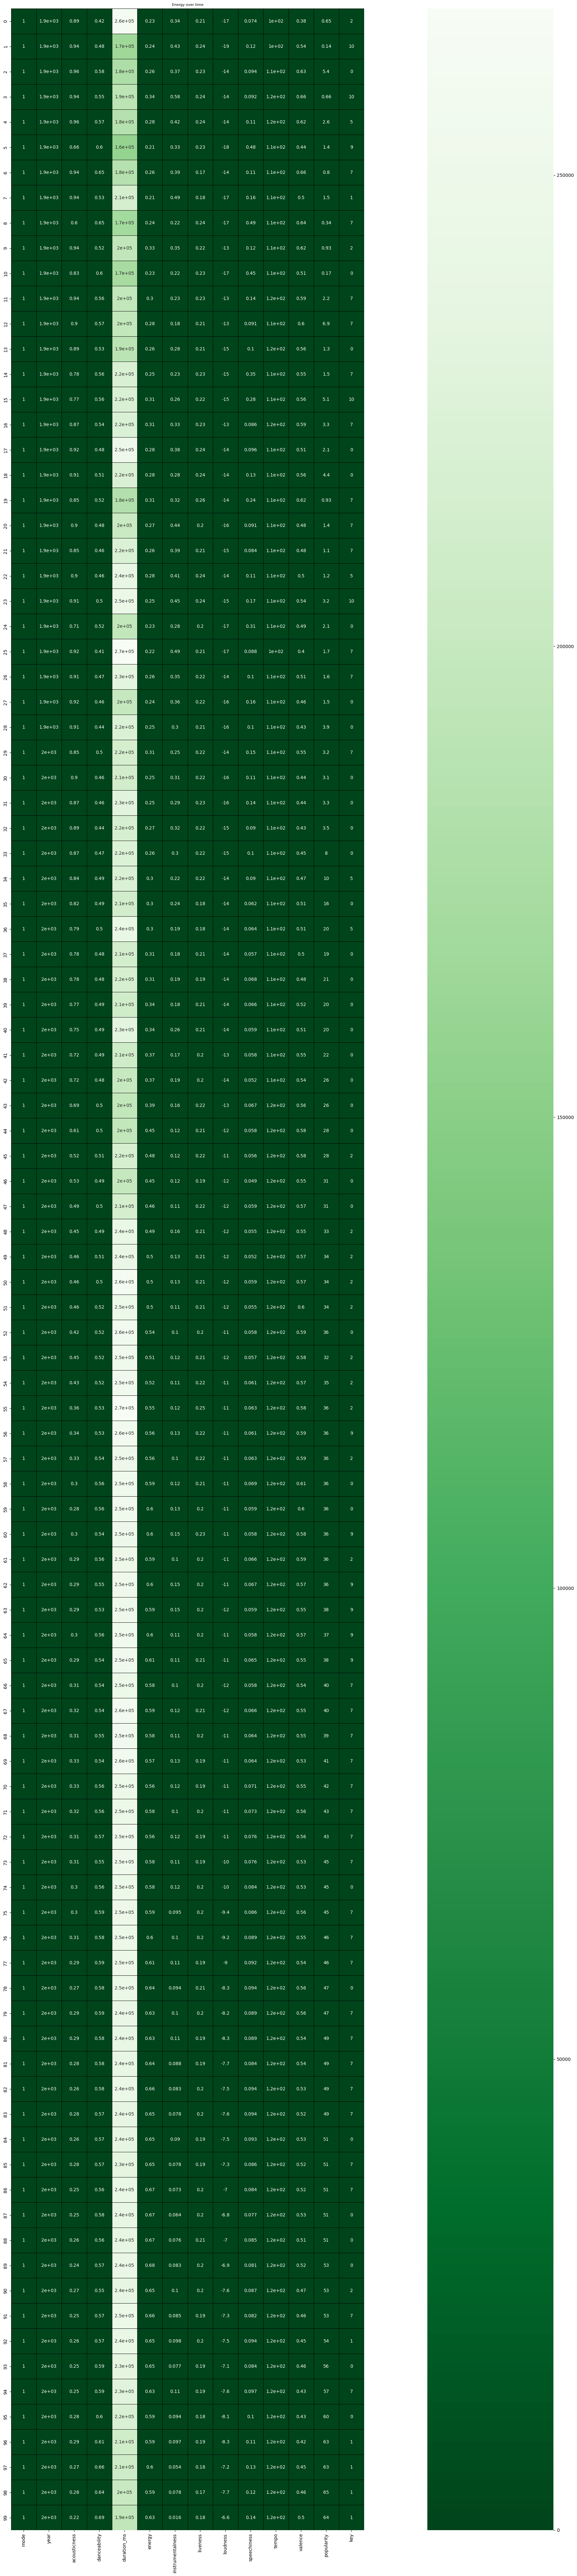

In [ ]:
year_data.pivot('year','duration_ms','energy').head()
plt.figure(figsize=(50,100))
pivot_table = year_data.pivot('year','duration_ms','energy')
plt.xlabel('year', size = 8)
plt.ylabel('duration_ms', size = 8)
plt.title('Energy over time', size = 8)
sns.heatmap(year_data, annot=True, linewidths=.4,linecolor='black', square=True, cmap='Greens_r',cbar=True);

<Axes: xlabel='explicit', ylabel='popularity'>

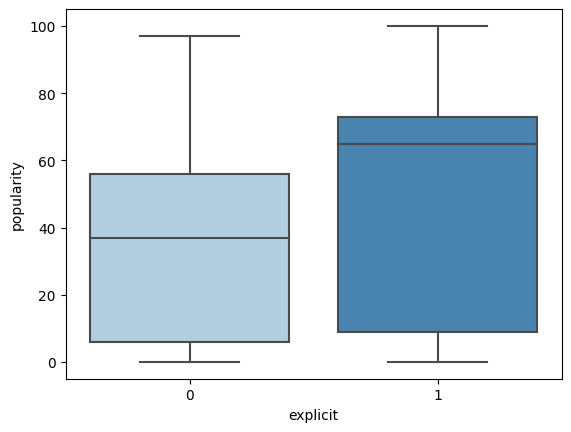

In [ ]:
plot_df = pd.read_csv('/content/data.csv')
sns.boxplot(x='explicit', y='popularity', data=plot_df, palette='Blues' )

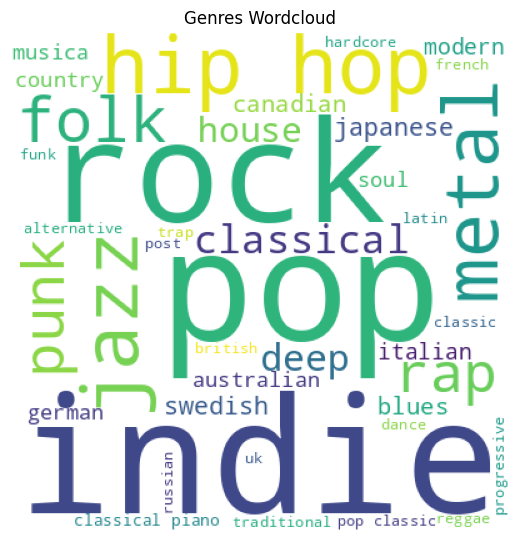

In [ ]:
from wordcloud import WordCloud,STOPWORDS

stopwords = set(STOPWORDS)
comment_words = " ".join(genre_data['genres'])+" "
wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = stopwords,
                max_words=40,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (5,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Genres Wordcloud")
plt.show()

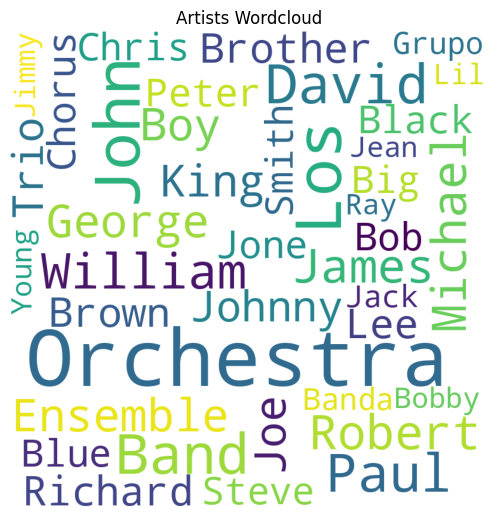

In [ ]:
stopwords = set(STOPWORDS)
comment_words = " ".join(artist_data['artists'])+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_word_length=3,
                max_words=40,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Artists Wordcloud")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
top10_popular_artists = artist_data.nlargest(10, 'popularity')
top10_most_song_produced_artists = artist_data.nlargest(10, 'count')

In [ ]:
print('Top 10 Artists that produced most songs:')
top10_most_song_produced_artists[['count','artists']].sort_values('count',ascending=False)

Top 10 Artists that produced most songs:


,count,artists
8367,3169,Francisco Canaro
28561,2422,Эрнест Хемингуэй
28560,2136,Эрих Мария Ремарк
8434,1459,Frank Sinatra
10714,1256,Ignacio Corsini
27109,1200,Vladimir Horowitz
1682,1146,Arturo Toscanini
2707,1103,Billie Holiday
12378,1061,Johnny Cash
7426,1023,Elvis Presley


In [ ]:
print('Top 10 Artists that had most popularity score:')
top10_popular_artists[['popularity','artists']].sort_values('popularity',ascending=False)

Top 10 Artists that had most popularity score:


,popularity,artists
20966,93.0,Ritt Momney
14354,92.0,Lele Pons
15070,90.0,Los Legendarios
11764,89.0,Jerry Di
7463,88.0,Emilee
23687,88.0,Surf Mesa
28263,88.0,salem ilese
213,87.0,A7S
2343,86.0,Beltito
14378,86.0,Lenny Santos


## **Conclusions from EDA**  

* Most of the songs range between 1950s-2010s.
* Energy in songs have increased over the time.
* Acousticness in songs have reduced greately over the decades.
* We can clearly see that loudness has dominantly increased over the decades and is at it's peak in 2020.
* In top 10 genres we can see that energy and dancebility are most noticable features.

# **Clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=12))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [ ]:
from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X) # returns np-array of coordinates(x,y) for each record after TSNE.
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'],title='Clusters of genres')
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.005s...
[t-SNE] Computed neighbors for 2973 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.106323
[t-SNE] KL divergence after 1000 iterations: 1.394114



# **Model**

* Based on the analysis and visualizations, it’s clear that similar
genres tend to have data points that are located close to each other while similar types of songs are also clustered together.

* This observation makes perfect sense. Similar genres will sound similar and will come from similar time periods while the same can be said for songs within those genres.

* We can use this idea to build a recommendation system by taking the data points of the songs a user has listened to and recommending songs corresponding to nearby data points.

* Spotify is a Python client for the Spotipy Web API that makes it easy for developers to fetch data and query Spotify’s catalog for songs.

* You have to install using pip install spotipy
After installing Spotipy, you will need to create an app on the Spotify Developer’s page and save your Client ID and secret key.

In [ ]:
!pip install spotipy

## Finds song details from spotify dataset. If song is unavailable in dataset, it returns none.

In [ ]:
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [ ]:
number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


### Fetches song details from dataset. If info is unavailable in dataset, it will search details from the spotify dataset.

In [ ]:

def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        print('Fetching song information from local dataset')
        return song_data

    except IndexError:
        print('Fetching song information from spotify dataset')
        return find_song(song['name'], song['year'])

### Fetches song info from dataset and does the mean of all numerical features of the song-data.

In [ ]:
def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    song_matrix = np.array(list(song_vectors))
#nd-array where n is number of songs in list. It contains all numerical vals of songs in sep list.
    print(f'song_matrix {song_matrix}')
    return np.mean(song_matrix, axis=0)

## Flattenning the dictionary by grouping the key and forming a list of values for respective key.

In [ ]:
def flatten_dict_list(dict_list):
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = [] # 'name', 'year'
    for dic in dict_list:
        for key,value in dic.items():
            flattened_dict[key].append(value) # creating list of values
    return flattened_dict

* Gets song list as input.

* Get mean vectors of numerical features of the input.

* Scale the mean-input as well as dataset numerical features.

* calculate eculidean distance b/w mean-input and dataset.

* Fetch the top 10 songs with maximum similarity.

In [ ]:
def recommend_songs( song_list, spotify_data, n_songs=10):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    #print(f'song_center {song_center}')
    scaler = song_cluster_pipeline.steps[0][1] # StandardScalar()
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    #print(f'distances {distances}')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

# **Making a recommendation System using Correlation Distance**

In [ ]:
def make_matrix_correlation(data,song,number):
    df=pd.DataFrame()
    data.drop_duplicates(inplace=True)
    songs=data['song_name'].values
#    best = difflib.get_close_matches(song,songs,1)[0]
    best=find_word(song,songs)
    print('The song closest to your search is :',best)
    genre=data[data['song_name']==best]['genre'].values[0]
    df=data[data['genre']==genre]
    x=df[df['song_name']==best].drop(columns=['genre','song_name']).values
    if len(x)>1:
        x=x[1]
    song_names=df['song_name'].values
    df.drop(columns=['genre','song_name'],inplace=True)
    df=df.fillna(df.mean())
    p=[]
    count=0
    for i in df.values:
        p.append([distance.correlation(x,i),count])
        count+=1
    p.sort()
    for i in range(1,number+1):
        print(song_names[p[i][1]])

In [ ]:
e=input('Please enter The name of the song :')
f=int(input('Please enter the number of recommendations you want: '))


Please enter The name of the song :Perfect
Please enter the number of recommendations you want: 4



# **Conclusion**

We are able to recommend top 10 similar songs to user based on the input. The recommendation is based on similarity of numerical features of the songs. We have calculated the cosine distance and identified the songs with highest similarity.